# NAWEA WOMBAT Interactive Example

NOTE: This workshop is based on the v0.9.2 release of WOMBAT.

First, import the necessary packages and make adjust some of the Pandas display settings.

In [1]:
from time import perf_counter
from pathlib import Path

import pandas as pd

from wombat import Simulation
from wombat.utilities import plot

pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

## Set up and demonstration of `Simulation`

First, we create a variable for our library directory, relative to this notebook, and have `Path` resolve it to ensure it exists. Then, we'll create a simulation for both an in situ and tow-to-port simulation (pre-configured in `library/corewind/project/config/`).

Note that a random seed is being set at the simulation level so that the same results get produced every single time these are run.

In [2]:
library_path = Path("../library/corewind/").resolve()

sim_in_situ = Simulation(
    library_path=library_path, config="morro_bay_in_situ.yaml", random_seed=34
)
sim_ttp = Simulation(
    library_path=library_path, config="morro_bay_tow_to_port.yaml", random_seed=34
)

### View the farm to verify it's what we saw in the slides

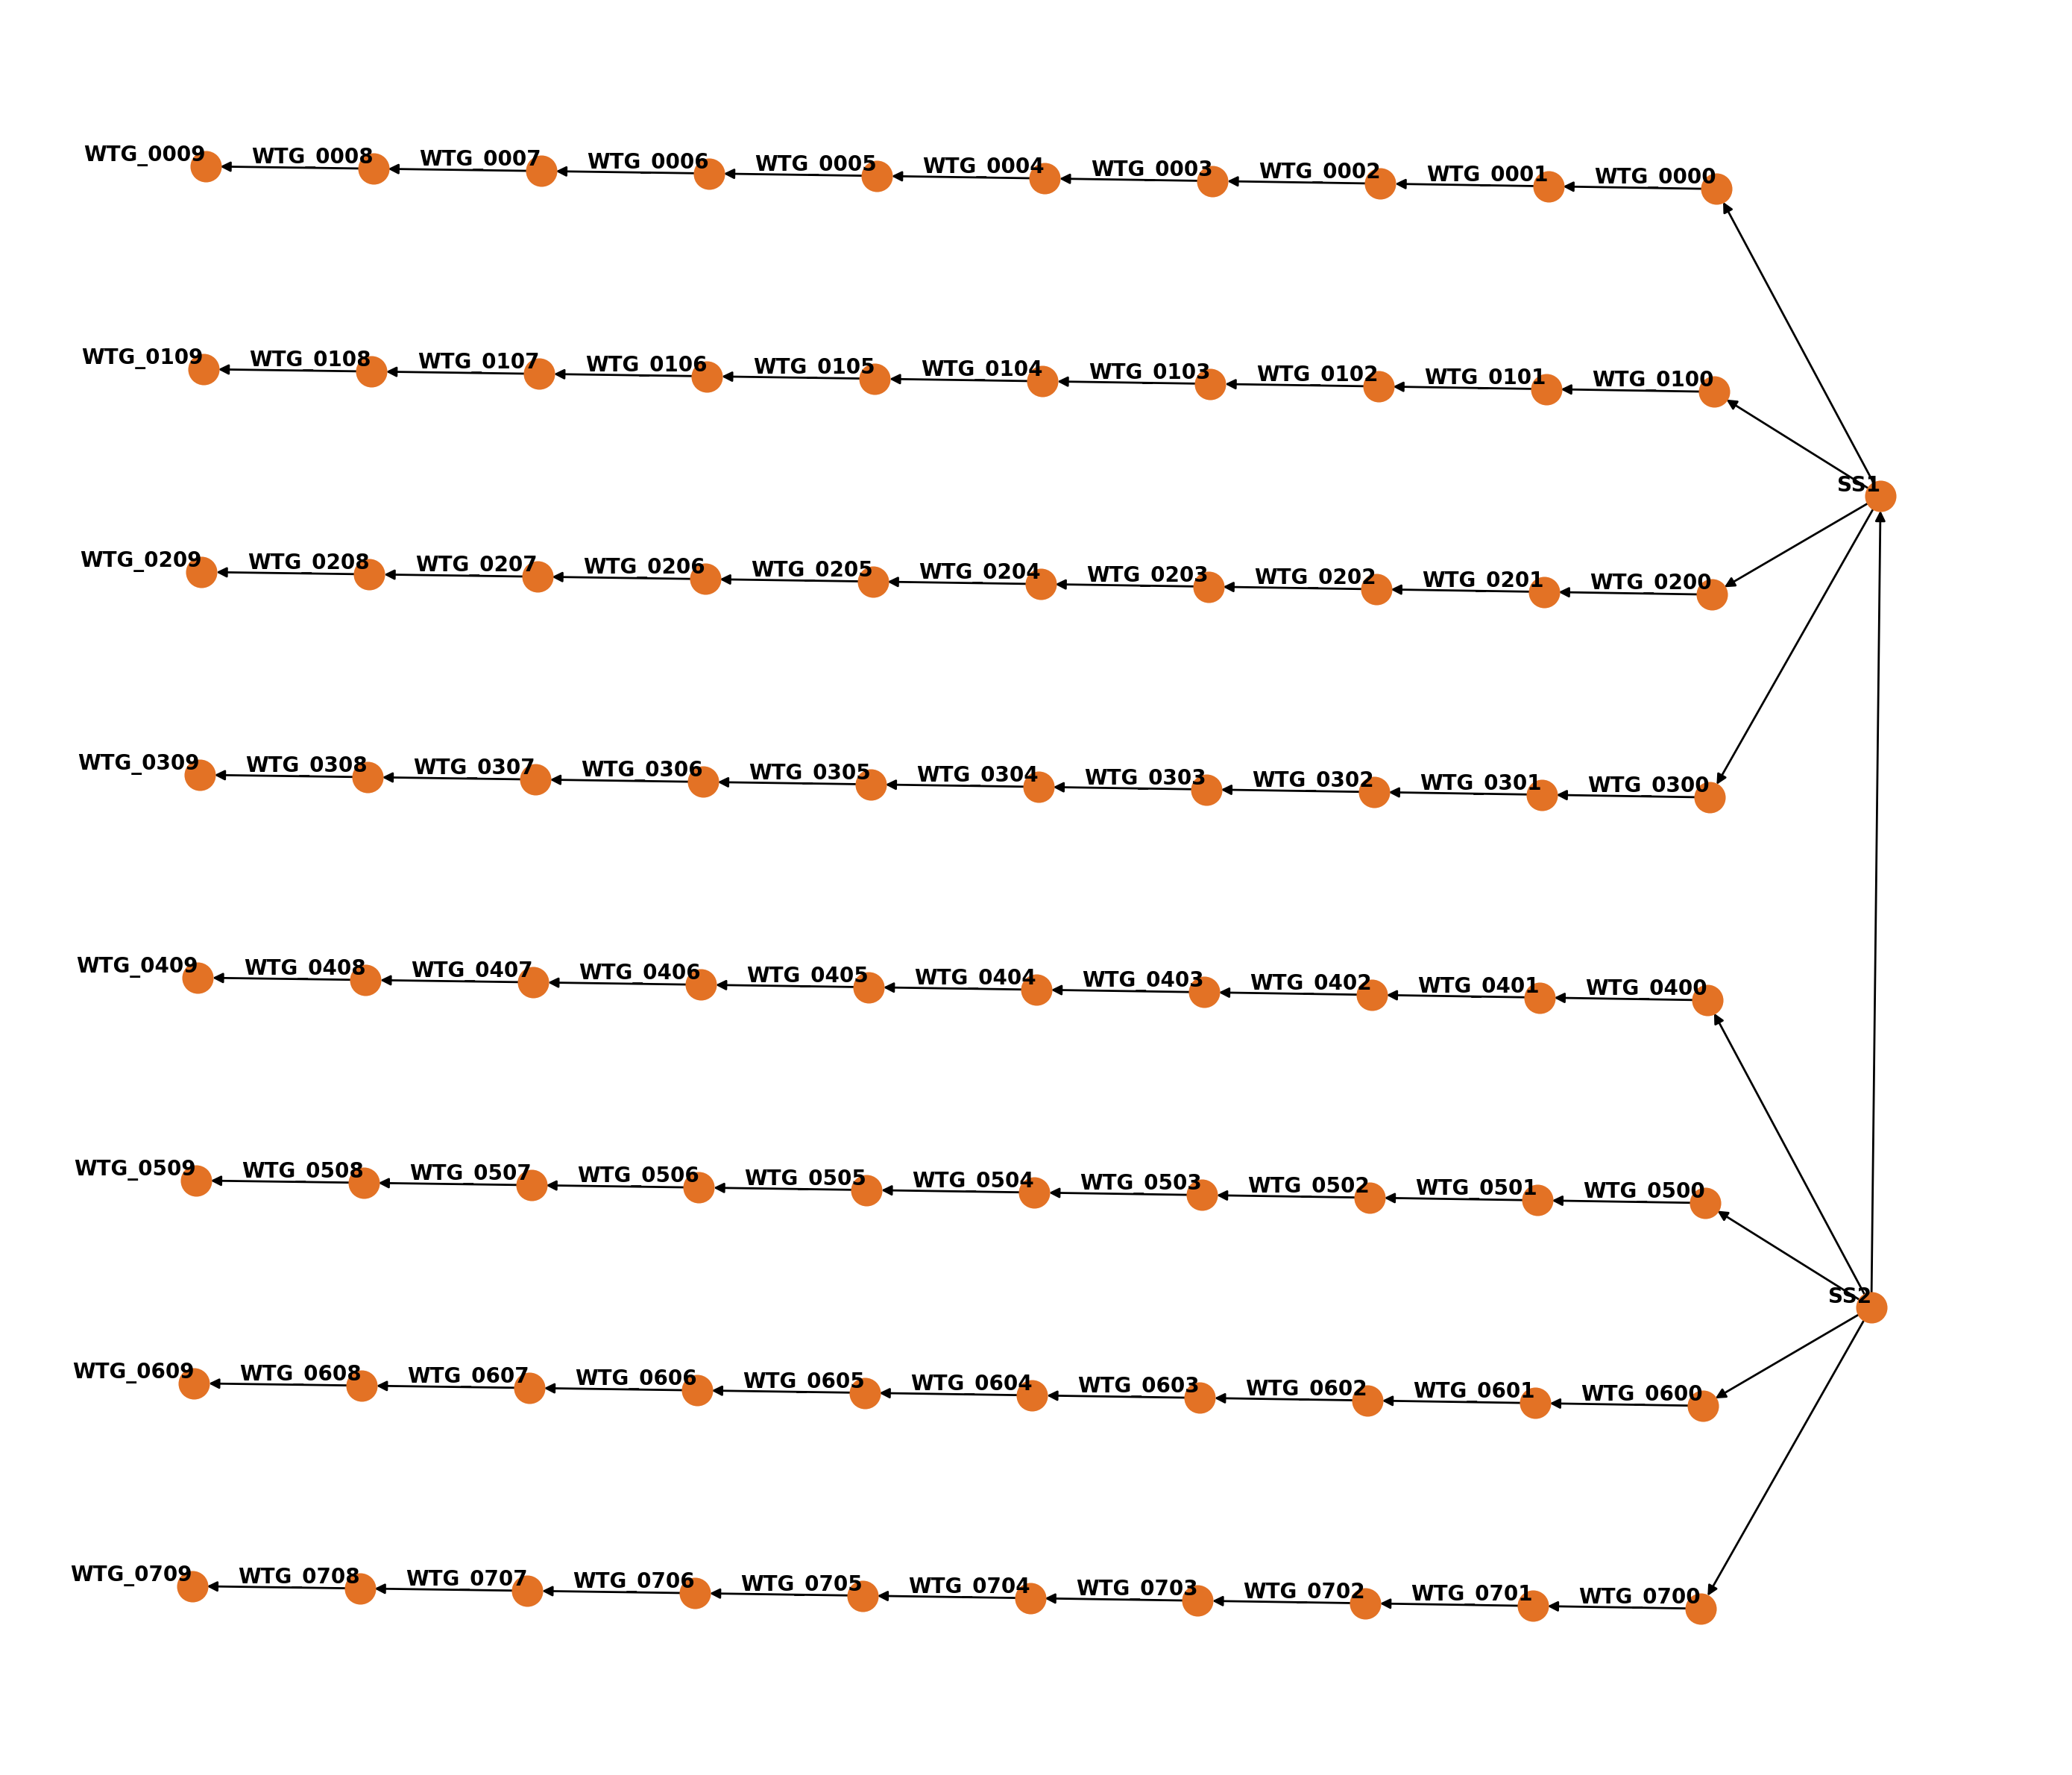

In [3]:
plot.plot_farm_layout(sim_in_situ.windfarm, plot_kwargs={"node_size": 200})

### Show some of the connections that `Simulation` creates that can be helpful for debugging

Sometimes simulations fail, and when that happens we might need to dig into what's going, which is often at the service equipment level because that is where much of the strategy configuration is coming from.

First, we'll see that simulations have a service equipment dictionary controlled by the `name` that we gave them.

In [4]:
list(sim_in_situ.service_equipment.keys())

['Crew Transfer Vessel 1',
 'Crew Transfer Vessel 2',
 'Crew Transfer Vessel 3',
 'Crew Transfer Vessel 4',
 'Crew Transfer Vessel 5',
 'Crew Transfer Vessel 6',
 'Crew Transfer Vessel 7',
 'Cable Laying Vessel',
 'Diving Support Vessel',
 'Anchor Handling Tug',
 'Heavy Lift Vessel']

In [5]:
list(sim_ttp.service_equipment.keys())

['Crew Transfer Vessel 1',
 'Crew Transfer Vessel 2',
 'Crew Transfer Vessel 3',
 'Crew Transfer Vessel 4',
 'Crew Transfer Vessel 5',
 'Crew Transfer Vessel 6',
 'Crew Transfer Vessel 7',
 'Cable Laying Vessel',
 'Diving Support Vessel',
 'Anchor Handling Tug',
 'Tugboat 1',
 'Tugboat 2']

Now, let's confirm that our work shifts are set up to be what we discussed.

In [6]:
sim_in_situ.service_equipment["Crew Transfer Vessel 1"].settings.workday_start

6

In [7]:
sim_in_situ.service_equipment["Heavy Lift Vessel"].settings.workday_start

0

## Run the simulations

To run a simulation, all we have to do is call `run()` and that will run it until the end of our configured simulation timeframe. Optionally, inputs such as `until=` can be used to control how many simulation hours the simulation will be run (1 year = 8760 hours, but be weary of leap years in your weather timeseries).

In [8]:
start = perf_counter()
sim_in_situ.run()
end = perf_counter()
print(f"Run time: {(end - start):.2f} seconds")

Run time: 57.25 seconds


In [9]:
start = perf_counter()
sim_ttp.run()
end = perf_counter()
print(f"Run time: {(end - start):.2f} seconds")

Run time: 209.26 seconds


## View the results

Now a `metrics` object will be available through the `Simulation` that gives access to the results methods, which provides all the metrics calculations that are pre-configured within WOMBAT, and gives access to the resulting energy, operations, and events logs.

### Availability

Note that the time-based availability is much higher than the production-based availability, which is due to the fact that the time basis cares about if the farm is operational at all, compared to the actual operational levels. If we were to dig into the individual turbines, we would find that the two availabilities would look similar, though the time-based would still trend higher.

In [10]:
print("In Situ Availability")
print(
    f"Time-based: {sim_in_situ.metrics.time_based_availability('project', 'windfarm').values[0][0]:.2%}"
)
print(
    f"Production-based: {sim_in_situ.metrics.production_based_availability('project', 'windfarm').values[0][0]:.2%}"
)
print()
print("Tow-to-Port Availability")
print(
    f"Time-based: {sim_ttp.metrics.time_based_availability('project', 'windfarm').values[0][0]:.2%}"
)
print(
    f"Production-based: {sim_ttp.metrics.production_based_availability('project', 'windfarm').values[0][0]:.2%}"
)

In Situ Availability
Time-based: 90.77%
Production-based: 90.57%

Tow-to-Port Availability
Time-based: 92.09%
Production-based: 91.91%


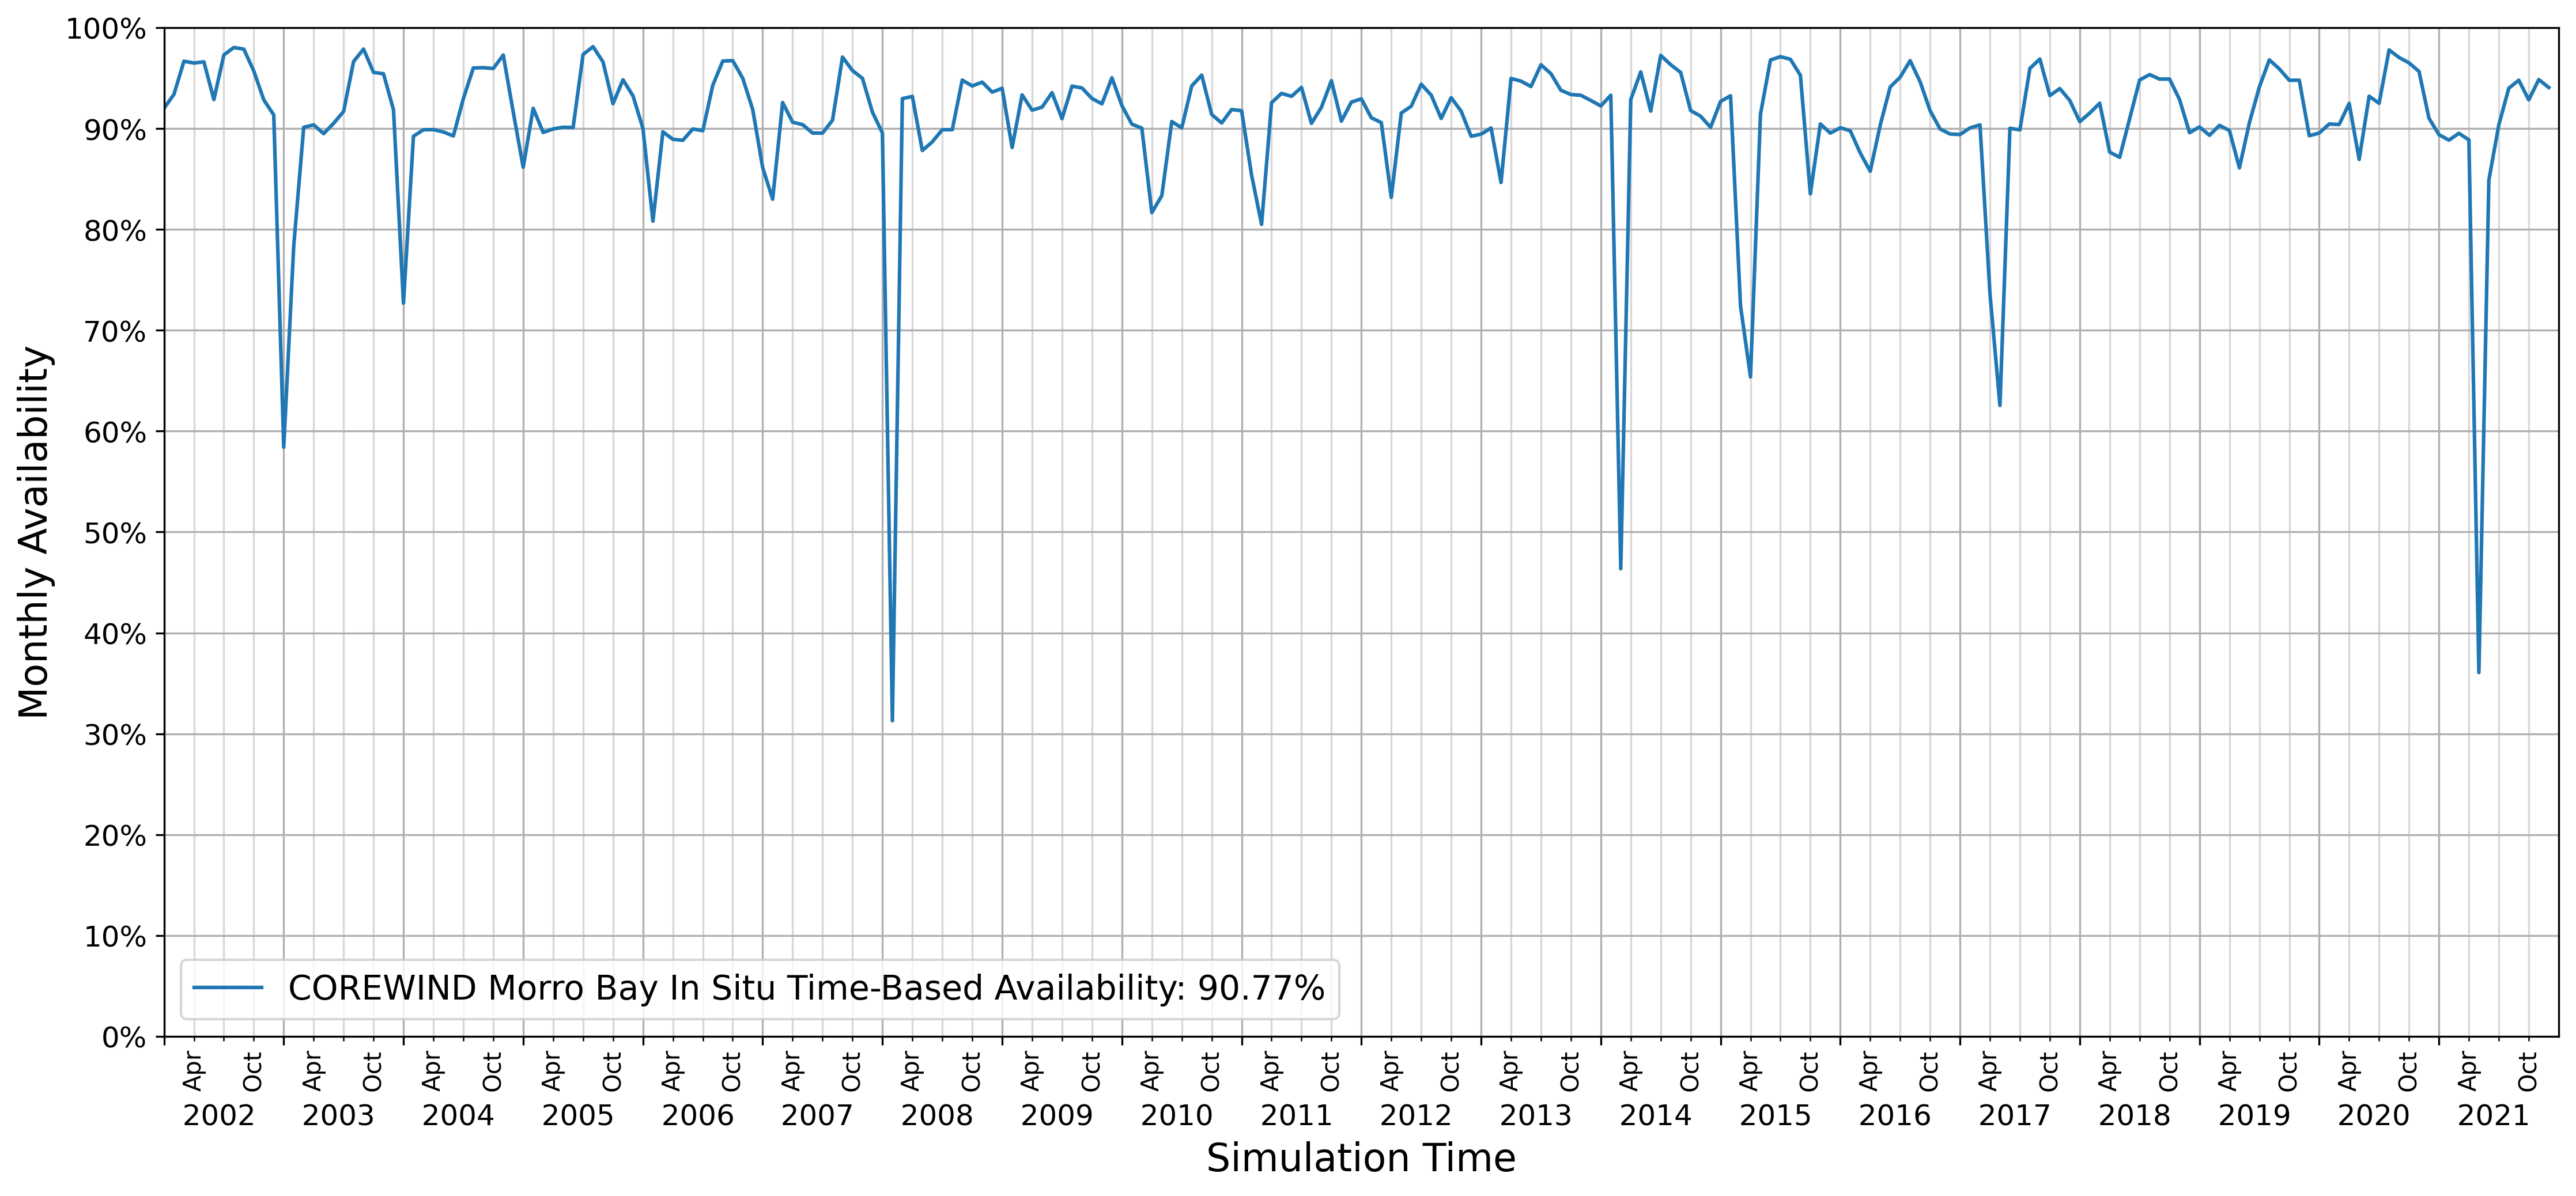

In [11]:
plot.plot_farm_availability(sim_in_situ, which="time")

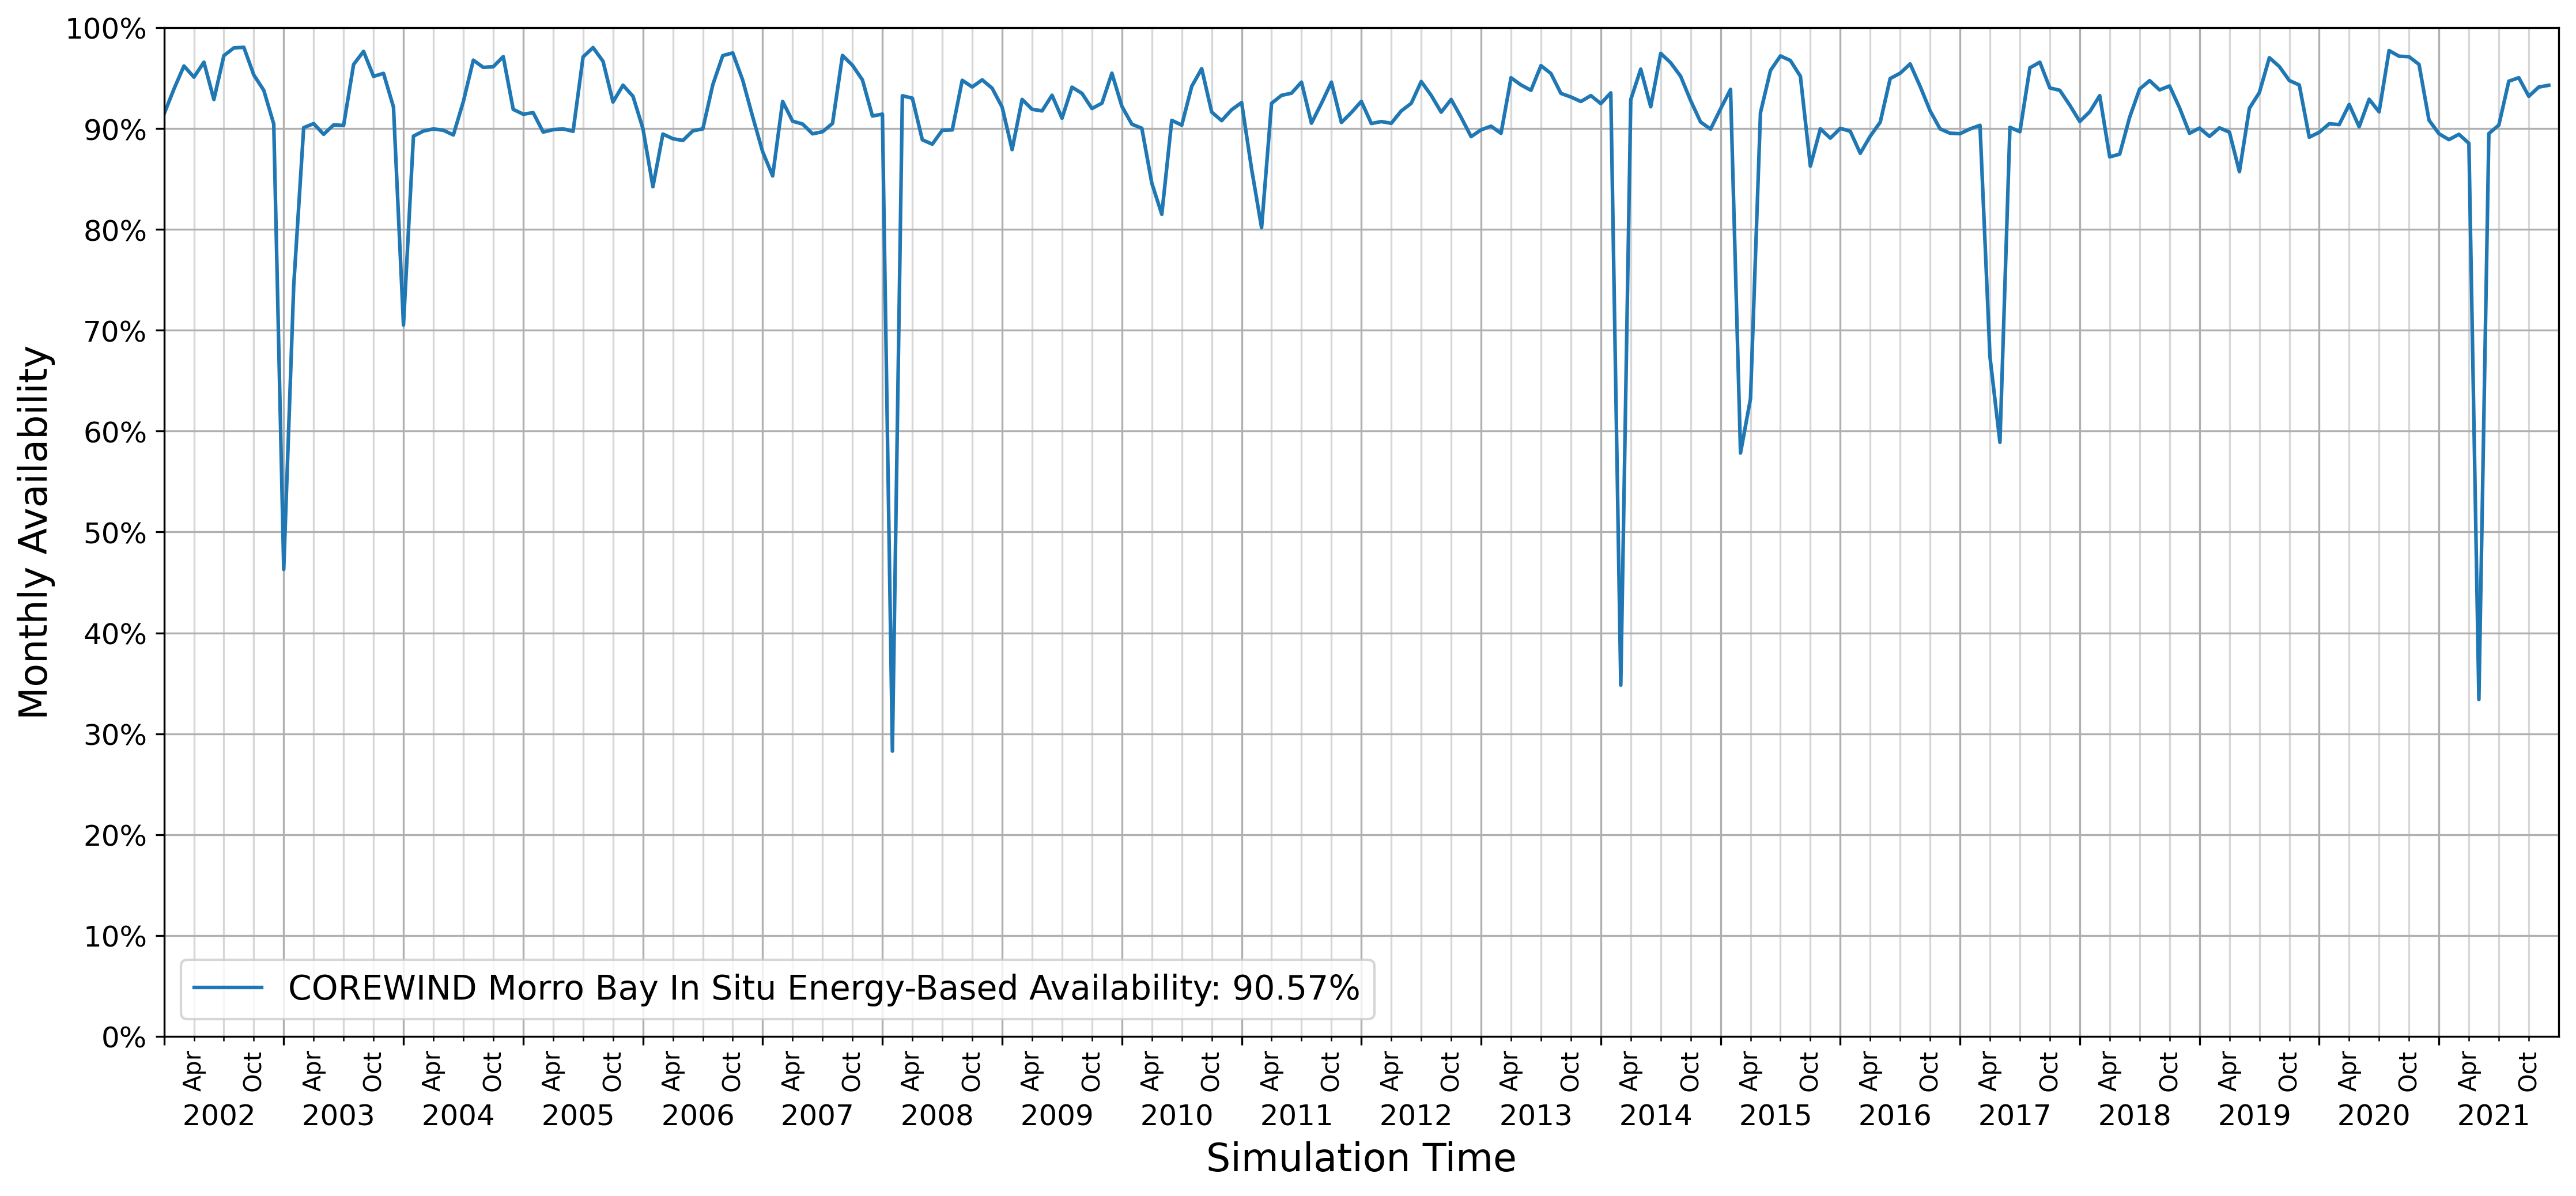

In [12]:
plot.plot_farm_availability(sim_in_situ, which="energy")

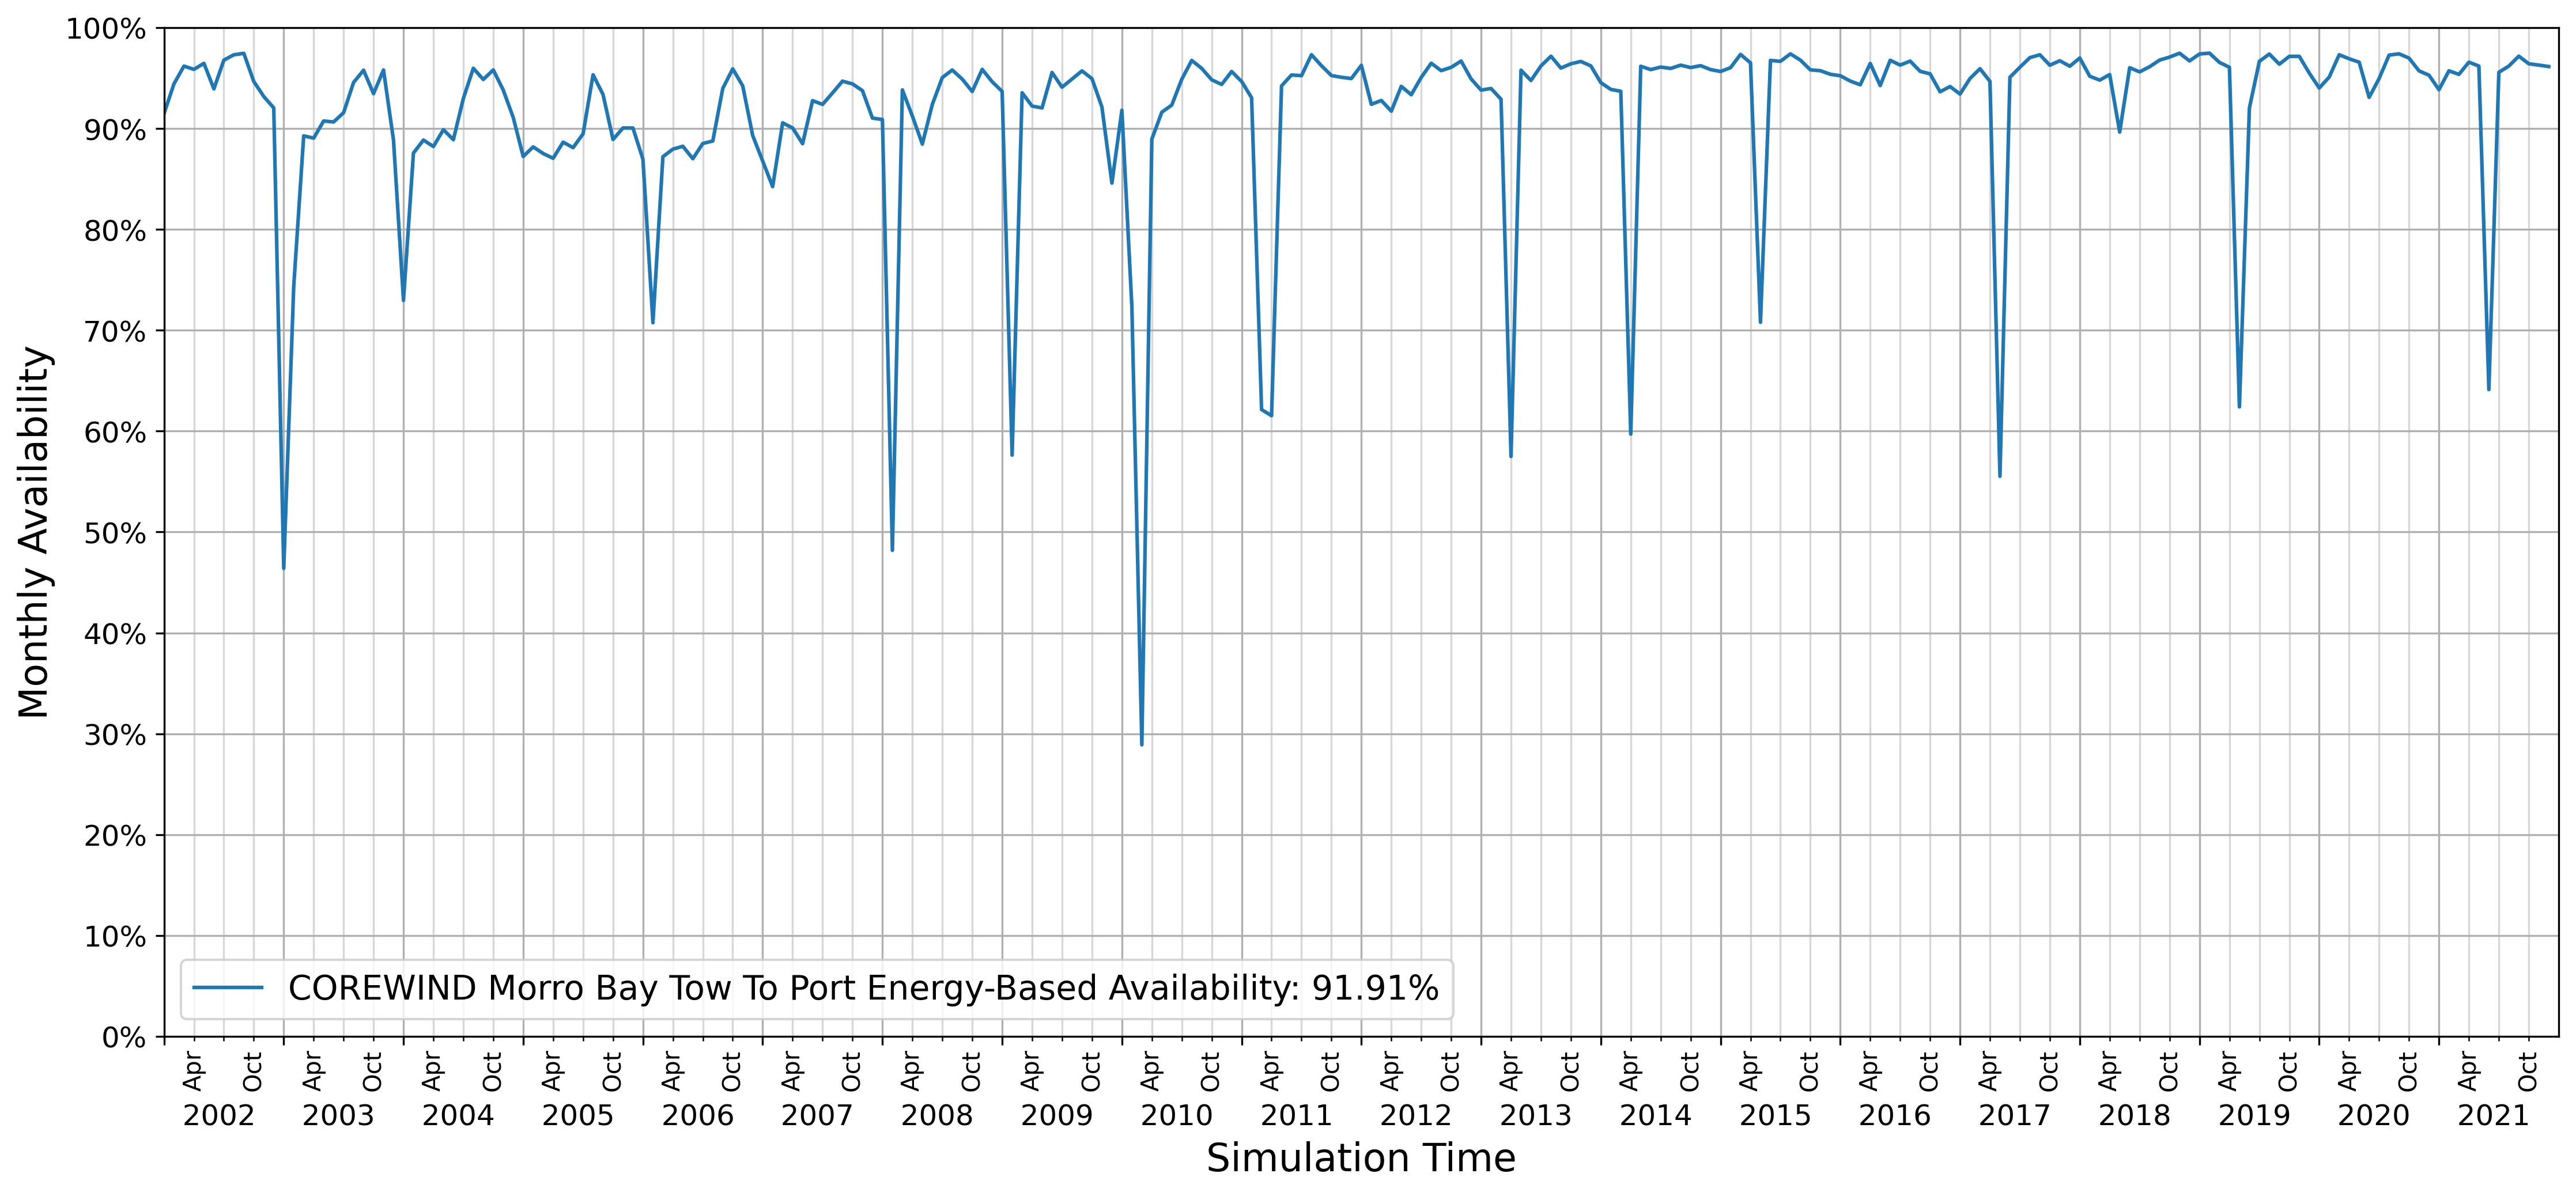

In [13]:
plot.plot_farm_availability(sim_ttp)

In the in situ case, we can see a large dip in availability in January 2003, and in the tow-to-port case we can see a large dip around February 2007, so let's investiage a bit further by diving into the events and operations logs that are available through the `Metrics` object.

In [14]:
ev_in_situ = sim_in_situ.metrics.events
op_in_situ = sim_in_situ.metrics.operations

In [15]:
op_in_situ.head()

,env_datetime,env_time,WTG_0000,WTG_0001,WTG_0002,WTG_0003,WTG_0004,WTG_0005,WTG_0006,WTG_0007,WTG_0008,WTG_0009,WTG_0100,WTG_0101,WTG_0102,WTG_0103,WTG_0104,WTG_0105,WTG_0106,WTG_0107,WTG_0108,WTG_0109,WTG_0200,WTG_0201,WTG_0202,WTG_0203,WTG_0204,WTG_0205,WTG_0206,WTG_0207,WTG_0208,WTG_0209,WTG_0300,WTG_0301,WTG_0302,WTG_0303,WTG_0304,WTG_0305,WTG_0306,WTG_0307,WTG_0308,WTG_0309,WTG_0400,WTG_0401,WTG_0402,WTG_0403,WTG_0404,WTG_0405,WTG_0406,WTG_0407,WTG_0408,WTG_0409,WTG_0500,WTG_0501,WTG_0502,WTG_0503,WTG_0504,WTG_0505,WTG_0506,WTG_0507,WTG_0508,WTG_0509,WTG_0600,WTG_0601,WTG_0602,WTG_0603,WTG_0604,WTG_0605,WTG_0606,WTG_0607,WTG_0608,WTG_0609,WTG_0700,WTG_0701,WTG_0702,WTG_0703,WTG_0704,WTG_0705,WTG_0706,WTG_0707,WTG_0708,WTG_0709,SS1,SS2,windfarm,year,month,day
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-02-14 16:20:26.112987,2002-01-01 00:00:00,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1.0,2002,1,1
2025-02-14 16:20:26.129073,2002-01-01 01:00:00,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1.0,2002,1,1
2025-02-14 16:20:26.129186,2002-01-01 02:00:00,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1.0,2002,1,1
2025-02-14 16:20:26.129233,2002-01-01 03:00:00,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1.0,2002,1,1
2025-02-14 16:20:26.129278,2002-01-01 04:00:00,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1.0,2002,1,1


In [16]:
op_in_situ.loc[
    op_in_situ.windfarm < 0.45, ["env_datetime", "env_time", "windfarm"]
].head(24)

,env_datetime,env_time,windfarm
datetime,,,
2025-02-14 16:20:27.576239,2003-01-21 10:00:00,9250,0.0
2025-02-14 16:20:27.576298,2003-01-21 11:00:00,9251,0.0
2025-02-14 16:20:27.576341,2003-01-21 12:00:00,9252,0.0
2025-02-14 16:20:27.578197,2003-01-21 13:00:00,9253,0.0
2025-02-14 16:20:27.578375,2003-01-21 14:00:00,9254,0.0
2025-02-14 16:20:27.579396,2003-01-21 15:00:00,9255,0.0
2025-02-14 16:20:27.579984,2003-01-21 16:00:00,9256,0.0
2025-02-14 16:20:27.580362,2003-01-21 17:00:00,9257,0.0
2025-02-14 16:20:27.580407,2003-01-21 18:00:00,9258,0.0


In [17]:
ev_in_situ.head().T  # transposed because of a bug in Jupyter Lab 4.0

datetime,2025-02-14 16:20:23.444340,2025-02-14 16:20:23.450881,2025-02-14 16:20:23.455995,2025-02-14 16:20:23.461102,2025-02-14 16:20:23.466678
env_datetime,2002-01-01 00:00:00,2002-01-01 00:00:00,2002-01-01 00:00:00,2002-01-01 00:00:00,2002-01-01 00:00:00
env_time,0.0,0.0,0.0,0.0,0.0
agent,WTG_0000,WTG_0001,WTG_0002,WTG_0003,WTG_0004
action,"subassemblies created: ['electrical_system', '...","subassemblies created: ['electrical_system', '...","subassemblies created: ['electrical_system', '...","subassemblies created: ['electrical_system', '...","subassemblies created: ['electrical_system', '..."
reason,windfarm initialization,windfarm initialization,windfarm initialization,windfarm initialization,windfarm initialization
additional,initialization,initialization,initialization,initialization,initialization
system_id,WTG_0000,WTG_0001,WTG_0002,WTG_0003,WTG_0004
system_name,WTG_0000,WTG_0001,WTG_0002,WTG_0003,WTG_0004
part_id,<NA>,<NA>,<NA>,<NA>,<NA>
part_name,<NA>,<NA>,<NA>,<NA>,<NA>


In [18]:
# Get the core subset of columns to show
col_filter = [
    "env_datetime",
    "agent",
    "action",
    "reason",
    "additional",
    "system_id",
    "part_id",
    "request_id",
    "duration",
]

So let's look for anything that seems like it could cause some major downtime around this timeframe.

In [19]:
ev_in_situ.loc[ev_in_situ.env_datetime >= "2003-01-20", col_filter].head(50)

,env_datetime,agent,action,reason,additional,system_id,part_id,request_id,duration
datetime,,,,,,,,,
2025-02-14 16:20:27.565450,2003-01-20 06:00:00,Crew Transfer Vessel 4,traveling,minor pitch system repair,traveling from port to site,WTG_0004,hydraulic_system,RPR00000315,1.809705
2025-02-14 16:20:27.565557,2003-01-20 06:00:00,Crew Transfer Vessel 6,traveling,minor pitch system repair,traveling from port to site,WTG_0202,hydraulic_system,RPR00000307,1.80978
2025-02-14 16:20:27.565663,2003-01-20 06:00:00,Crew Transfer Vessel 3,traveling,major pitch system repair,traveling from port to site,WTG_0505,hydraulic_system,RPR00000360,1.809797
2025-02-14 16:20:27.565769,2003-01-20 06:00:00,Crew Transfer Vessel 1,traveling,blades minor repair,traveling from port to site,WTG_0007,rotor_blades,RPR00000430,1.809801
2025-02-14 16:20:27.565873,2003-01-20 06:00:00,Crew Transfer Vessel 7,traveling,minor pitch system repair,traveling from port to site,WTG_0009,hydraulic_system,RPR00000311,1.809824
2025-02-14 16:20:27.565975,2003-01-20 06:00:00,Crew Transfer Vessel 5,traveling,minor pitch system repair,traveling from port to site,WTG_0407,hydraulic_system,RPR00000314,1.80985
2025-02-14 16:20:27.566077,2003-01-20 06:00:00,Crew Transfer Vessel 2,traveling,minor pitch system repair,traveling from port to site,WTG_0402,hydraulic_system,RPR00000309,1.809853
2025-02-14 16:20:27.566177,2003-01-20 07:48:35,Crew Transfer Vessel 4,complete travel,minor pitch system repair,arrived at WTG_0004,WTG_0004,hydraulic_system,RPR00000315,0.0
2025-02-14 16:20:27.566379,2003-01-20 07:48:35,Crew Transfer Vessel 4,transferring crew,minor pitch system repair,transferring crew from Crew Transfer Vessel 4 ...,WTG_0004,hydraulic_system,RPR00000315,0.25


So, we have a substation inspection, so in order to operate on that it'll get shut down, which then shuts down all energy passing through it, which could cause some major curtailment. Now, let's see how long that might be lasting

In [20]:
ev_in_situ.loc[ev_in_situ.env_datetime >= "2003-01-20 09:50", col_filter].head(20)

,env_datetime,agent,action,reason,additional,system_id,part_id,request_id,duration
datetime,,,,,,,,,
2025-02-14 16:20:27.567339,2003-01-20 12:01:08,generator,maintenance request,annual turbine inspection,severity level 0,WTG_0102,generator,MNT00000431,0.0
2025-02-14 16:20:27.567368,2003-01-20 12:01:08,supporting_structure,maintenance request,structural annual inspection,severity level 0,WTG_0102,supporting_structure,MNT00000432,0.0
2025-02-14 16:20:27.567489,2003-01-20 12:54:45,Crew Transfer Vessel 3,transferring crew,major pitch system repair,transferring crew from WTG_0505 to Crew Transf...,WTG_0505,hydraulic_system,RPR00000360,0.25
2025-02-14 16:20:27.567538,2003-01-20 13:09:45,Crew Transfer Vessel 3,complete transfer,major pitch system repair,complete,WTG_0505,hydraulic_system,RPR00000360,0.0
2025-02-14 16:20:27.567577,2003-01-20 13:09:45,Crew Transfer Vessel 3,repair complete,major pitch system repair,complete,WTG_0505,hydraulic_system,RPR00000360,0.0
2025-02-14 16:20:27.568179,2003-01-20 13:09:54,Crew Transfer Vessel 3,traveling,power converter minor repair,traveling from WTG_0505 to WTG_0704,WTG_0704,electrical_system,RPR00000316,0.130429
2025-02-14 16:20:27.568186,2003-01-20 13:17:44,Crew Transfer Vessel 3,complete travel,power converter minor repair,arrived at WTG_0704,WTG_0704,electrical_system,RPR00000316,0.0
2025-02-14 16:20:27.568402,2003-01-20 13:17:44,Crew Transfer Vessel 3,transferring crew,power converter minor repair,transferring crew from Crew Transfer Vessel 3 ...,WTG_0704,electrical_system,RPR00000316,0.25
2025-02-14 16:20:27.568423,2003-01-20 13:32:44,Crew Transfer Vessel 3,complete transfer,power converter minor repair,complete,WTG_0704,electrical_system,RPR00000316,0.0


Ok, so now it's clear that both substations are having simultaneous downtime, which will inevitable shut down the whole farm. Let's just see how long that might last for

In [21]:
ss1_maint = ev_in_situ.loc[ev_in_situ.request_id == "MNT00000325", col_filter]
ss1_maint

,env_datetime,agent,action,reason,additional,system_id,part_id,request_id,duration
datetime,,,,,,,,,
2025-02-14 16:20:27.476382,2003-01-01 00:00:00,supporting_structure,maintenance request,structural annual inspection,severity level 0,WTG_0604,supporting_structure,MNT00000325,0.0
2025-02-14 16:20:27.650232,2003-02-06 16:11:37,Crew Transfer Vessel 6,traveling,structural annual inspection,traveling from WTG_0604 to WTG_0604,WTG_0604,supporting_structure,MNT00000325,0.0
2025-02-14 16:20:27.650242,2003-02-06 16:11:37,Crew Transfer Vessel 6,complete travel,structural annual inspection,arrived at WTG_0604,WTG_0604,supporting_structure,MNT00000325,0.0
2025-02-14 16:20:27.650448,2003-02-06 16:11:37,Crew Transfer Vessel 6,transferring crew,structural annual inspection,transferring crew from Crew Transfer Vessel 6 ...,WTG_0604,supporting_structure,MNT00000325,0.25
2025-02-14 16:20:27.650454,2003-02-06 16:26:37,Crew Transfer Vessel 6,complete transfer,structural annual inspection,complete,WTG_0604,supporting_structure,MNT00000325,0.0
2025-02-14 16:20:27.650496,2003-02-06 16:26:37,Crew Transfer Vessel 6,maintenance,structural annual inspection,maintenance,WTG_0604,supporting_structure,MNT00000325,5.306389
2025-02-14 16:20:27.654979,2003-02-06 21:45:00,Crew Transfer Vessel 6,transferring crew,structural annual inspection,transferring crew from WTG_0604 to Crew Transf...,WTG_0604,supporting_structure,MNT00000325,0.25
2025-02-14 16:20:27.655601,2003-02-06 22:00:00,Crew Transfer Vessel 6,complete transfer,structural annual inspection,complete,WTG_0604,supporting_structure,MNT00000325,0.0
2025-02-14 16:20:27.655703,2003-02-06 22:00:00,Crew Transfer Vessel 6,traveling,structural annual inspection,traveling from site to port,WTG_0604,supporting_structure,MNT00000325,1.809788


So, the request is submitted, and 20 days later it's addressed, so let's figure out roughly how long the downtime actually is here. And then what about the other substation's maintenance?

In [22]:
ss1_maint = ss1_maint.loc[ss1_maint.agent == "Crew Transfer Vessel 2"]
ss1_maint.env_datetime.max() - ss1_maint.env_datetime.min()

NaT

In [23]:
ss2_maint = ev_in_situ.loc[ev_in_situ.request_id == "MNT00000326", col_filter]

ss2_maint.head()

,env_datetime,agent,action,reason,additional,system_id,part_id,request_id,duration
datetime,,,,,,,,,
2025-02-14 16:20:27.476465,2003-01-01 00:00:00,transformer,maintenance request,oss annual inspection,severity level 1,SS1,transformer,MNT00000326,0.0
2025-02-14 16:20:27.570346,2003-01-20 15:49:46,Crew Transfer Vessel 2,traveling,oss annual inspection,traveling from WTG_0402 to SS1,SS1,transformer,MNT00000326,0.227779
2025-02-14 16:20:27.570402,2003-01-20 16:03:26,Crew Transfer Vessel 2,complete travel,oss annual inspection,arrived at SS1,SS1,transformer,MNT00000326,0.0
2025-02-14 16:20:27.570481,2003-01-20 16:03:26,Crew Transfer Vessel 2,transferring crew,oss annual inspection,transferring crew from Crew Transfer Vessel 2 ...,SS1,transformer,MNT00000326,0.25
2025-02-14 16:20:27.570487,2003-01-20 16:18:26,Crew Transfer Vessel 2,complete transfer,oss annual inspection,complete,SS1,transformer,MNT00000326,0.0


In [24]:
ss2_maint = ss2_maint.loc[ss2_maint.agent == "Crew Transfer Vessel 7"]
ss2_maint.env_datetime.max() - ss2_maint.env_datetime.min()

NaT

So there are 2 simultaneous dips in availability, first from maintenance on the the upstream substation (SS1), and then from maintenance on the main, interconnection-connected substation (SS2), which then causes a shutdown at the entire plant.

So then what happens for the tow-to-port case?

In [25]:
# Exercise for those that want to try it on their own

### Cost breakdowns

Now we can look at the OpEx and see how they compare from one scenario to the next, and break it down by other categories as needed or interested.

In [26]:
project_mw = sim_in_situ.windfarm.capacity / 1000

In [27]:
opex = sim_in_situ.metrics.opex("project")
opex.index = ["In Situ"]
opex.loc["Tow-to-Port", "OpEx"] = sim_ttp.metrics.opex("project").values[0]
opex["OpEx (€/MW/yr)"] = opex.OpEx / project_mw / 20
opex = opex.rename(columns={"OpEx": "OpEx (€)"})
opex.style.format("{:,.2f}")

,OpEx (€),OpEx (€/MW/yr)
In Situ,"2,374,449,536.67","98,935.40"
Tow-to-Port,"1,638,630,272.56","68,276.26"


In [28]:
opex_breakdown = pd.concat(
    [
        sim_in_situ.metrics.equipment_costs("project"),
        sim_in_situ.metrics.labor_costs("project"),
        sim_in_situ.metrics.project_fixed_costs("project", "low"),
        sim_in_situ.metrics.port_fees("project"),
    ],
    axis=1,
)
opex_breakdown.index = ["In Situ"]
opex_breakdown.loc["Tow-to-Port"] = pd.concat(
    [
        sim_ttp.metrics.equipment_costs("project"),
        sim_ttp.metrics.labor_costs("project"),
        sim_ttp.metrics.project_fixed_costs("project", "low"),
        sim_ttp.metrics.port_fees("project"),
    ],
    axis=1,
).values[0]
opex_breakdown.style.format("{:,.2f}")

,equipment_cost,total_labor_cost,operations,port_fees
In Situ,"2,274,924,948.23","48,935,360.44",0.00,0.00
Tow-to-Port,"1,027,098,070.73","72,228,657.83",0.00,"480,000,000.00"


Why might the OpEx for tow-to-port be so low?

In [29]:
equipment_breakdown = pd.concat(
    [
        sim_in_situ.metrics.equipment_costs("project", by_equipment=True).T.rename(
            columns={0: "In Situ"}
        ),
        sim_ttp.metrics.equipment_costs("project", by_equipment=True).T.rename(
            columns={0: "Tow-to-Port"}
        ),
    ],
    join="outer",
    axis=1,
).fillna(0)
equipment_breakdown.style.format("{:,.2f}")

/var/folders/q5/tfpytqxn0r396dfg7rk5sj8rwq9tvv/T/ipykernel_57566/4175670550.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ).fillna(0)


,In Situ,Tow-to-Port
Anchor Handling Tug,"103,020,925.76","345,792,942.79"
Cable Laying Vessel,"130,130,098.58","138,242,990.46"
Crew Transfer Vessel 1,"25,563,213.13","25,562,815.87"
Crew Transfer Vessel 2,"25,563,214.95","25,562,871.01"
Crew Transfer Vessel 3,"25,563,228.32","25,562,849.31"
Crew Transfer Vessel 4,"25,563,216.79","25,562,793.70"
Crew Transfer Vessel 5,"25,563,207.62","25,562,820.98"
Crew Transfer Vessel 6,"25,563,217.79","25,562,799.05"
Crew Transfer Vessel 7,"25,563,219.72","25,562,838.76"
Diving Support Vessel,"136,459,783.35","341,566,485.95"


It should be noted that there are a couple limitations to WOMBAT and this data:
1. Tugboats don't currently get mobilized, so those costs are missing from the equation
2. Tugboats are only actively accruing costs during their towing and travel duties, and not during the between time like other servicing equipment
3. There is no port usage fee, only a monthly access fee, and right now this is just coming directly from ORBIT, so it may not even be the correct amount for an O&M scenario

In the future, timing TBD, those will be addressed, but for now they're limitations, and should be considered when configuring the tow-to-port costs to match up with expected results

### Operational performance

Were the vessels used consistently throughout the simulation period? Note that the below metric probably needs to be updated to be more reflective of vessel inactive time, such as time between shifts, so there are some limitations to the current model

In [30]:
equipment_utilization = pd.concat(
    [
        sim_in_situ.metrics.service_equipment_utilization("project").T.rename(
            columns={0: "In Situ"}
        ),
        sim_ttp.metrics.service_equipment_utilization("project").T.rename(
            columns={0: "Tow-to-Port"}
        ),
    ],
    join="outer",
    axis=1,
).fillna(0)
equipment_utilization.style.format("{:,.2f}")

,In Situ,Tow-to-Port
Anchor Handling Tug,0.84,0.99
Cable Laying Vessel,0.91,0.91
Crew Transfer Vessel 1,1.00,1.00
Crew Transfer Vessel 2,1.00,1.00
Crew Transfer Vessel 3,1.00,1.00
Crew Transfer Vessel 4,1.00,1.00
Crew Transfer Vessel 5,1.00,1.00
Crew Transfer Vessel 6,1.00,1.00
Crew Transfer Vessel 7,1.00,1.00
Diving Support Vessel,0.90,0.97


What if we also look at the task completion rate? It seems that the tow-to-port scenario isn't actually getting tasks completed, so let's dig deeper.

In [31]:
print("In Situ")
scheduled = sim_in_situ.metrics.task_completion_rate(
    which="scheduled", frequency="project"
).values[0][0]
unscheduled = sim_in_situ.metrics.task_completion_rate(
    which="unscheduled", frequency="project"
).values[0][0]
combined = sim_in_situ.metrics.task_completion_rate(
    which="both", frequency="project"
).values[0][0]
print(f"  Scheduled Task Completion Rate: {scheduled:.2%}")
print(f"Unscheduled Task Completion Rate: {unscheduled:.2%}")
print(f"    Overall Task Completion Rate: {combined:.2%}")
print()
print("Tow-to-Port")
scheduled = sim_ttp.metrics.task_completion_rate(
    which="scheduled", frequency="project"
).values[0][0]
unscheduled = sim_ttp.metrics.task_completion_rate(
    which="unscheduled", frequency="project"
).values[0][0]
combined = sim_ttp.metrics.task_completion_rate(
    which="both", frequency="project"
).values[0][0]
print(f"  Scheduled Task Completion Rate: {scheduled:.2%}")
print(f"Unscheduled Task Completion Rate: {unscheduled:.2%}")
print(f"    Overall Task Completion Rate: {combined:.2%}")

In Situ
  Scheduled Task Completion Rate: 96.46%
Unscheduled Task Completion Rate: 96.11%
    Overall Task Completion Rate: 96.24%

Tow-to-Port
  Scheduled Task Completion Rate: 71.72%
Unscheduled Task Completion Rate: 76.93%
    Overall Task Completion Rate: 75.01%


So let's dig into how long it takes to start and complete repairs for each scenario

In [32]:
process_times = sim_ttp.metrics.process_times()

# Normalize the times for hours per failure, to understand the average waiting and repair time
time_columns = ["time_to_completion", "process_time", "downtime", "time_to_start"]
process_times.loc[:, time_columns] = process_times[
    time_columns
].values / process_times.N.values.reshape(-1, 1)

# Sort and make it look nice
process_times.sort_values("time_to_completion", ascending=False).style.format("{:,.0f}")

,time_to_completion,process_time,downtime,time_to_start,N
category,,,,,
yaw system major replacement,"20,250",110,110,"9,882",2
minor ballast pump repair,"16,370",23,81,"13,933",30
direct drive generator major repair,"15,323",49,709,"12,760",151
direct drive generator major replacement,"14,774",190,202,"11,442",35
annual turbine inspection,"12,666",34,148,"10,243","4,765"
main shaft major repair,"12,637",33,"1,770","11,289",59
main shaft replacement,"12,269",132,273,"11,039",25
direct drive generator minor repair,"11,877",23,55,"9,591","2,732"
yaw system major repair,"10,833",40,43,"10,793",12


How does that compare to the in situ case for some of our worst offenders?

In [33]:
process_times = sim_in_situ.metrics.process_times()

# Normalize the times for hours per failure, to understand the average waiting and repair time
time_columns = ["time_to_completion", "process_time", "downtime", "time_to_start"]
process_times.loc[:, time_columns] = process_times[
    time_columns
].values / process_times.N.values.reshape(-1, 1)

# Sort and make it look nice
process_times.sort_values("time_to_completion", ascending=False).head(10).style.format(
    "{:,.0f}"
)

,time_to_completion,process_time,downtime,time_to_start,N
category,,,,,
power converter major repair,"11,346",52,51,"9,180",497
yaw system major repair,"9,815",46,46,"9,774",10
main shaft major repair,"3,913",143,142,"3,792",37
blades major replacement,"3,624","3,003","3,003",621,1
power electrical system major repair,"3,619",149,149,"3,402",18
direct drive generator major repair,"3,522",212,212,"3,357",36
blades major repair,"1,872",128,128,"1,786",9
major pitch system replacement,"1,812",251,251,"1,685",2
power converter replacement,"1,706",602,602,"1,128",117


## What Next?

- What happens if we add more crew slots at the port to get repairs done?
- What if we add another HLV, does more work get done, or do we just divvy up the tasks more evenly?
- How do labor rates impact the analysis?
- What else do you want to explore?

NOTE: just remember to delete the logged data when you're done because the CSV files can take up a lot space if you don't need them and are just experimenting

In [34]:
sim_in_situ.env.cleanup_log_files()
sim_ttp.env.cleanup_log_files()